In [2]:
import os
import pandas as pd
import numpy as np
from helpers import VolleyWrapper, aggregate_similarities_all, show_analysed_frames, adjusted_r2
import tqdm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

os.chdir('/Users/jniedziela/Developer/master/bpe/')

DATA_DIR = 'attack_pose_data/'
SCORES_DATA = 'attack_pose_data/pose_scores.xlsx'
JSON_DATA_DIR = 'attack_pose_data/json_files/'
EXCEL_DATA_DIR = 'attack_pose_data/excel_files/'

/Users/jniedziela/.pyenv/versions/3.10.0/envs/bpe_2/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
SCORE_COLUMNS = [
    'aanloop_aantal_passen_score', # NUMBER OF STEPS B4 JUMP IF > 2 THEN 1 ELSE 0 (0 or 1)
    'rem_pas_score',  # LAST STEP (0 or 1)
    'sprong_hoek_score', # JUMP ANGLE (0 to 1)
    'positie_tov_bal_score', # POSITION RELATIVE TO BALL (0 or 1)
    'slagarm_hoek_score', # ATTACK ARM ANGLE (0 to 1)
    'totaal_score'
]

scores = pd.read_excel(SCORES_DATA, index_col=0)[['pose_tabel'] + SCORE_COLUMNS]
scores['json_file'] = scores['pose_tabel'].str.replace('.xlsx', '.json')
scores.sample(5)

,pose_tabel,aanloop_aantal_passen_score,rem_pas_score,sprong_hoek_score,positie_tov_bal_score,slagarm_hoek_score,totaal_score,json_file
4,GX010037_Clip_7_sec_15_POSE_tabel.xlsx,1,0,0.466667,1,0.850000,3.316667,GX010037_Clip_7_sec_15_POSE_tabel.json
31,GX010046_Clip_15_POSE_tabel.xlsx,1,1,0.555556,0,0.933333,3.488889,GX010046_Clip_15_POSE_tabel.json
23,GX010045_Clip_19_POSE_tabel.xlsx,1,1,0.433333,0,0.861111,3.294444,GX010045_Clip_19_POSE_tabel.json
3,GX010036_Clip_4_sec_16_POSE_tabel.xlsx,1,1,0.466667,0,0.883333,3.350000,GX010036_Clip_4_sec_16_POSE_tabel.json
15,GX010044_Clip_5_POSE_tabel.xlsx,1,0,0.600000,0,0.877778,2.477778,GX010044_Clip_5_POSE_tabel.json


In [4]:
best_scored_video = scores.sort_values('slagarm_hoek_score', ascending=False).iloc[0]
display(best_scored_video)
best_scored_video_file = best_scored_video['json_file']

pose_tabel                     GX010046_Clip_21_POSE_tabel.xlsx
aanloop_aantal_passen_score                                   1
rem_pas_score                                                 1
sprong_hoek_score                                      0.477778
positie_tov_bal_score                                         0
slagarm_hoek_score                                     0.961111
totaal_score                                           3.438889
json_file                      GX010046_Clip_21_POSE_tabel.json
Name: 34, dtype: object

In [5]:
# get frame in which attack happens (ball hit)
attack_frames = {}
for file in os.listdir(EXCEL_DATA_DIR):
    df = pd.read_excel(EXCEL_DATA_DIR + file)
    attack_frames[file.replace('.xlsx', '.json')] = df[df.phase == 'attack'][1:-1].Frame.iloc[0]

## Check whether top 10 embeddings give any good res

### R2 scores for regression on embeddings: 
#### - X is top n embeddings (based on single embedding prediction power)
#### - y is arm angle score (slagarm_hoek_score)

In [35]:
def plot_num_top_emb_vs_r2(df, y, max_n_embeddings=20):
    """
    Plots the explained variance ratio and R-squared score of a model trained
    on PCA-transformed data with different numbers of components.

    Args:
        df (dataframe): The feature dataframe with the original embeddings.
        y (array-like): The target variable vector.
    """

    best_embs = pd.DataFrame(columns=['emb', 'r2'])

    for emb_col in df.columns:
        X = df[emb_col].values.reshape(-1, 1)
        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)
        best_embs.loc[len(best_embs)] = [emb_col, r2]

    n_embeddings = range(1, max_n_embeddings + 1)  # Number of components to try
    r2_scores = []
    adjusted_r2_scores = []

    for n in n_embeddings:
        X = df[best_embs.sort_values('r2', ascending=False).iloc[:n].emb]

        model = LinearRegression()
        # Train the model
        model.fit(X, y)

        # Evaluate the model
        r2_scores.append(model.score(X, y))
        adjusted_r2_scores.append(adjusted_r2(r2_scores[-1], X.shape[0], X.shape[1]))

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(n_embeddings, r2_scores, label='R-squared Score')
    plt.plot(n_embeddings, adjusted_r2_scores, label='Adjusted R-squared Score')
    plt.xlabel('Number of embeddings')
    plt.ylabel('R-squared Score')
    plt.title('Number of embeddings vs. R-squared Score')
    plt.legend()
    plt.xticks(n_embeddings)
    plt.grid(True)
    plt.show()


Number of frames around attack: 14



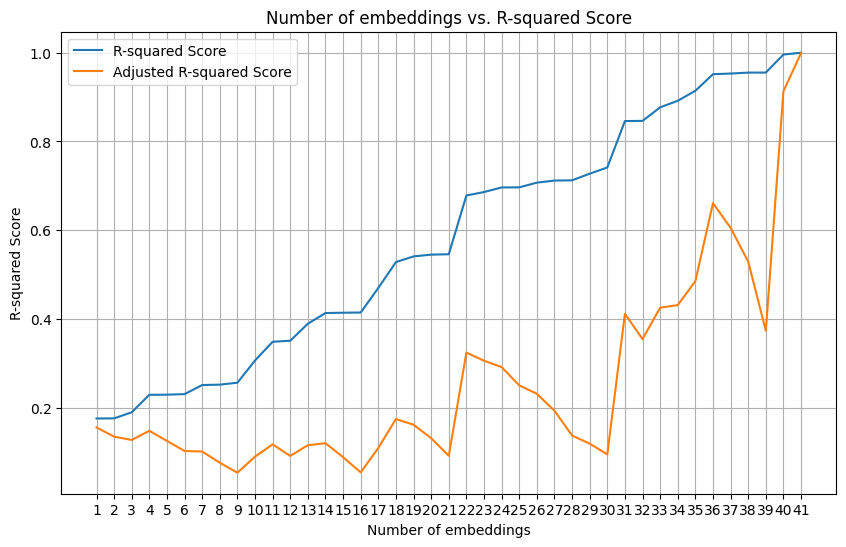


Number of frames around attack: 16



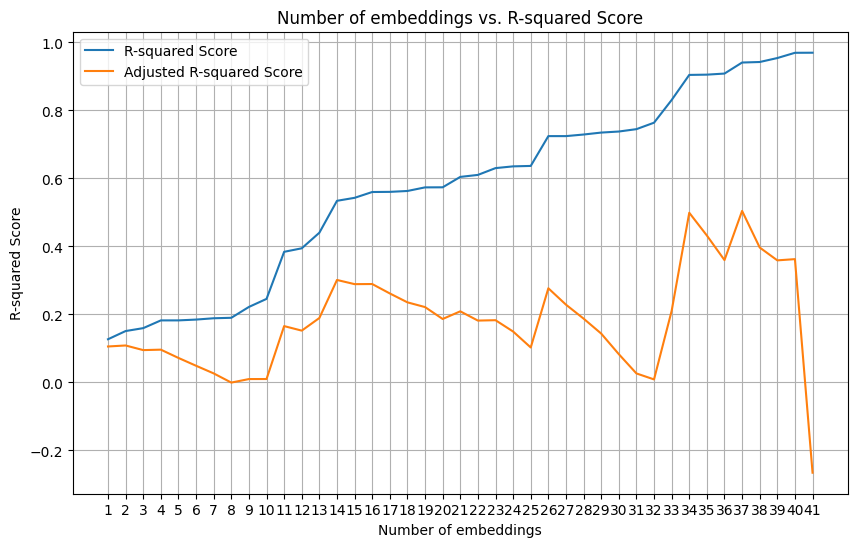


Number of frames around attack: 18



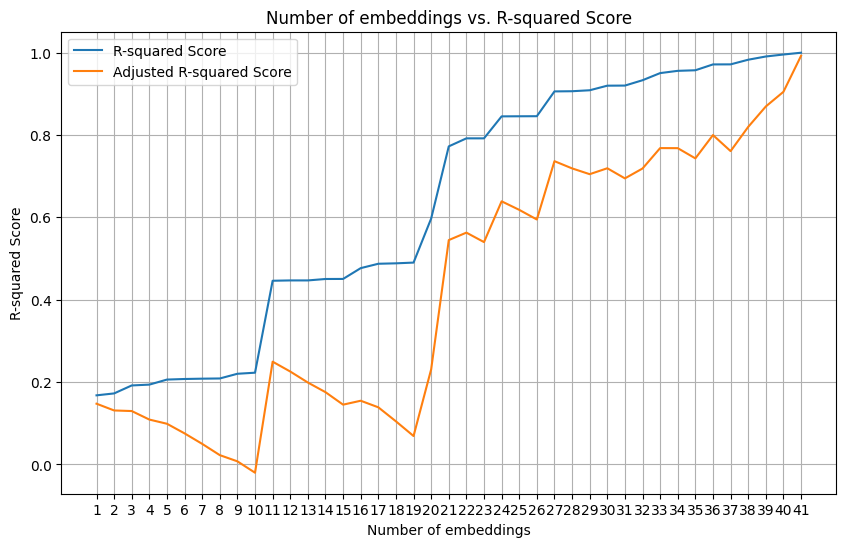


Number of frames around attack: 20



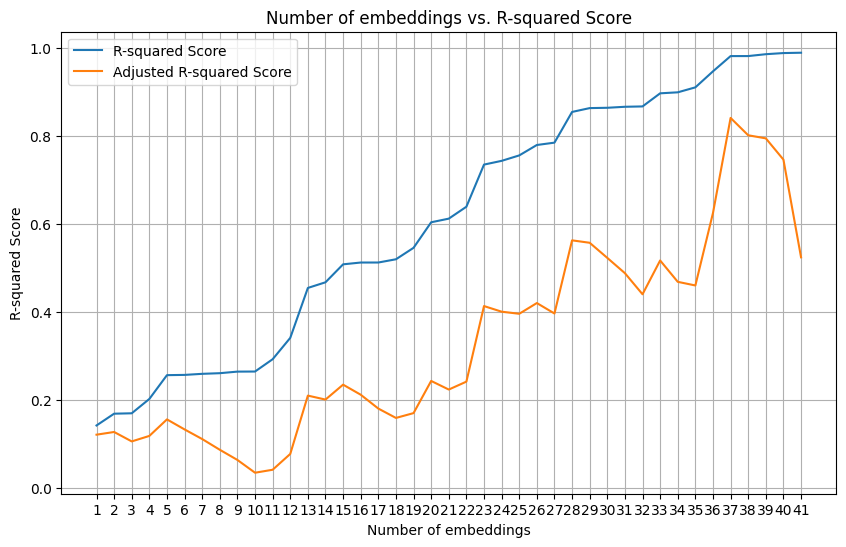


Number of frames around attack: 22



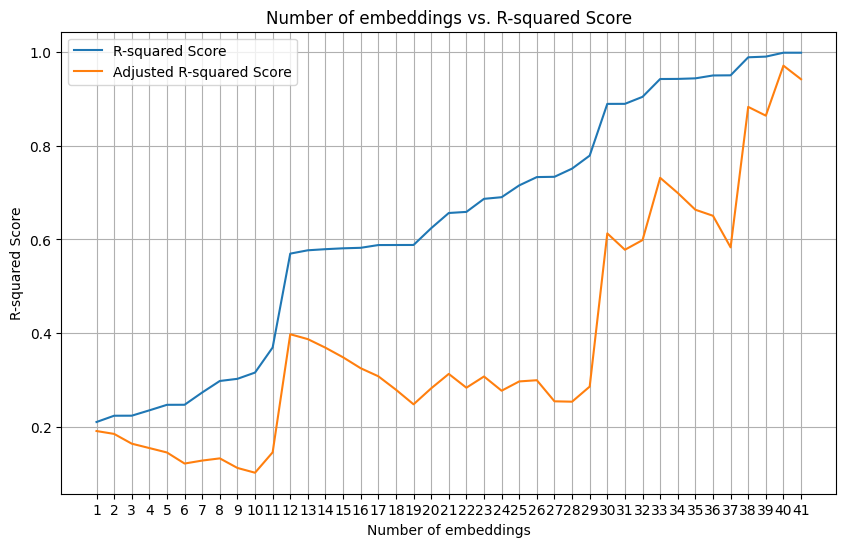


Number of frames around attack: 24



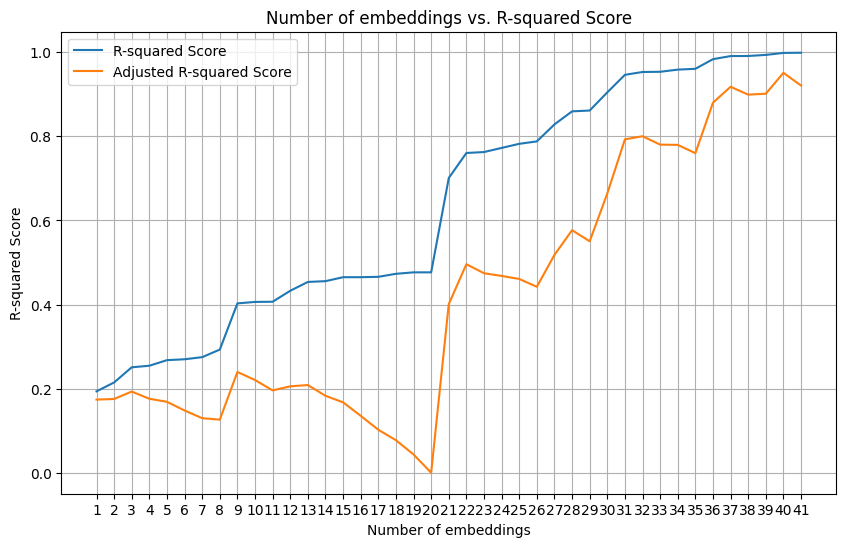


Number of frames around attack: 26



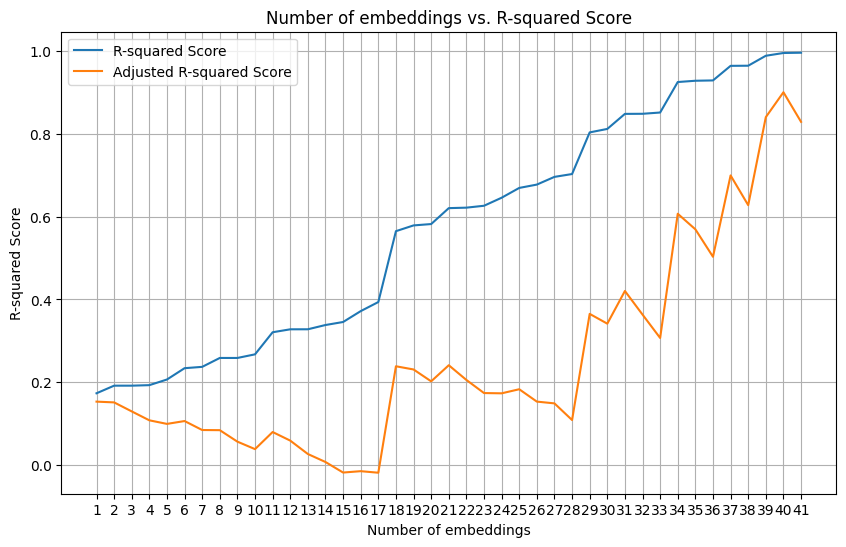


Number of frames around attack: 28



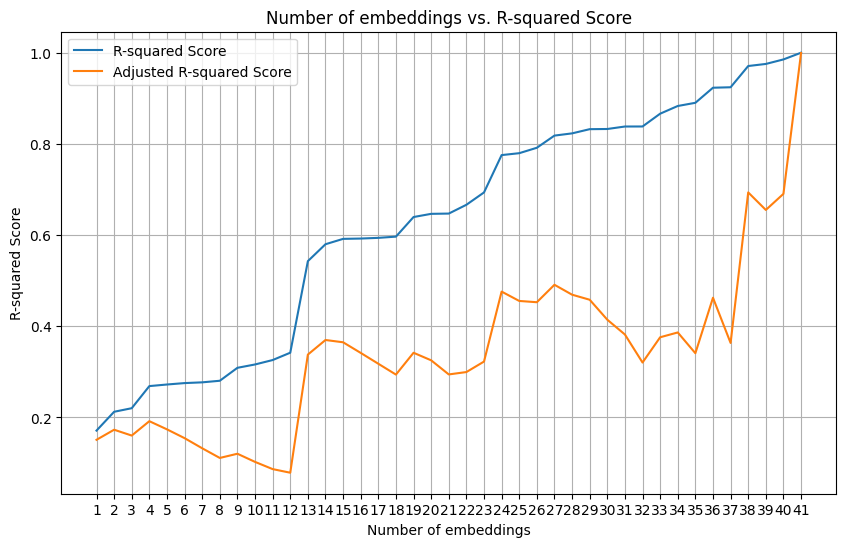


Number of frames around attack: 30



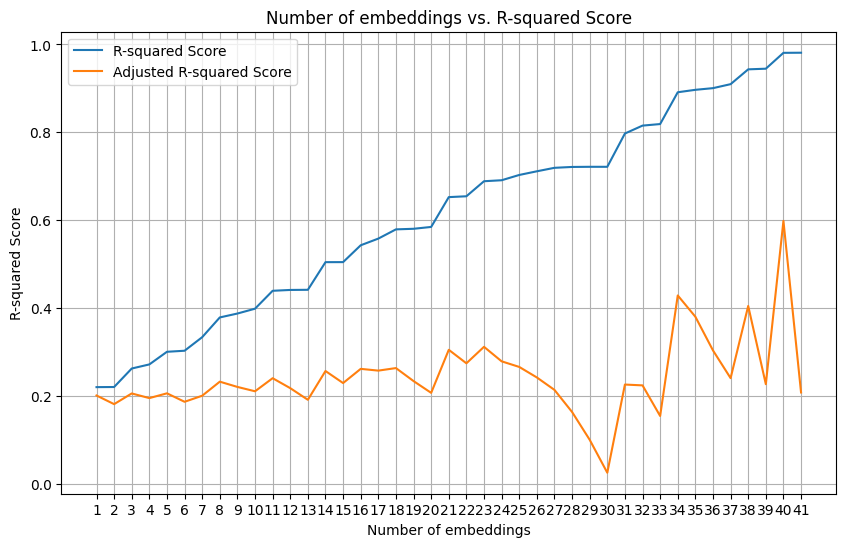

In [36]:
for num_frames_around_attack in range(14, 31, 2):
    ra_embeddings = {}

    print(f'\nNumber of frames around attack: {num_frames_around_attack}\n')

    for video, attack_frame in attack_frames.items():
        vid_path = JSON_DATA_DIR + video
        analyser = VolleyWrapper(vid_path, vid_path, window_size=num_frames_around_attack, stride=num_frames_around_attack)
        embeddings = analyser.embeddings(analyser.seq1[:, :, attack_frame - num_frames_around_attack // 2: attack_frame + num_frames_around_attack // 2], num_frames_around_attack, num_frames_around_attack)
        ra_embeddings[video] = embeddings[0][0]

    ra_embeddings = pd.DataFrame(ra_embeddings).T
    embs_len = len(ra_embeddings.columns)
    ra_embeddings.columns = [f'emb_{i}' for i in range(embs_len)]
    ra_embeddings['json_file'] = ra_embeddings.index
    ra_embeddings = ra_embeddings.reset_index(drop=True)
    ra_embeddings = ra_embeddings.merge(scores[['slagarm_hoek_score', 'positie_tov_bal_score', 'totaal_score', 'json_file']])
    y = ra_embeddings['slagarm_hoek_score']

    plot_num_top_emb_vs_r2(ra_embeddings[[f'emb_{i}' for i in range(embs_len)]], y, max_n_embeddings=41)

### Accuracy for classification
#### - X is top n embeddings (based on single embedding prediction power)
#### - y is arm position score (positie_tov_bal_score)

In [21]:
from sklearn.metrics import balanced_accuracy_score

def plot_num_top_emb_vs_acc(df, y, max_n_embeddings=20):
    """
    Plots the explained variance ratio and balanced accuracy score of a logistic regression model trained
    on top n embeddings.

    Args:
        df (dataframe): The feature dataframe with the original embeddings.
        y (array-like): The target variable vector.
    """

    best_embs = pd.DataFrame(columns=['emb', 'b_acc'])

    for emb_col in df.columns:
        X = df[emb_col].values.reshape(-1, 1)
        model = LogisticRegression().fit(X, y)
        pred = model.predict(X)
        b_acc = balanced_accuracy_score(y, pred)
        best_embs.loc[len(best_embs)] = [emb_col, b_acc]

    n_embeddings = range(1, max_n_embeddings + 1)  # Number of components to try
    acc_scores = []
    balanced_acc_scores = []

    for n in n_embeddings:
        X = df[best_embs.sort_values('b_acc', ascending=False).iloc[:n].emb]

        model = LogisticRegression()
        # Train the model
        model.fit(X, y)
        pred = model.predict(X)

        # Evaluate the model
        acc_scores.append(model.score(X, y))
        balanced_acc_scores.append(balanced_accuracy_score(y, pred))

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(n_embeddings, acc_scores, label='Accuracy Score')
    plt.plot(n_embeddings, balanced_acc_scores, label='Balanced Accuracy Score')
    plt.xlabel('Number of embeddings')
    plt.ylabel('Accuracy Scores')
    plt.title('Number of embeddings vs. Accuracy Scores')
    plt.legend()
    plt.xticks(n_embeddings)
    plt.grid(True)
    plt.show()


Number of frames around attack: 14



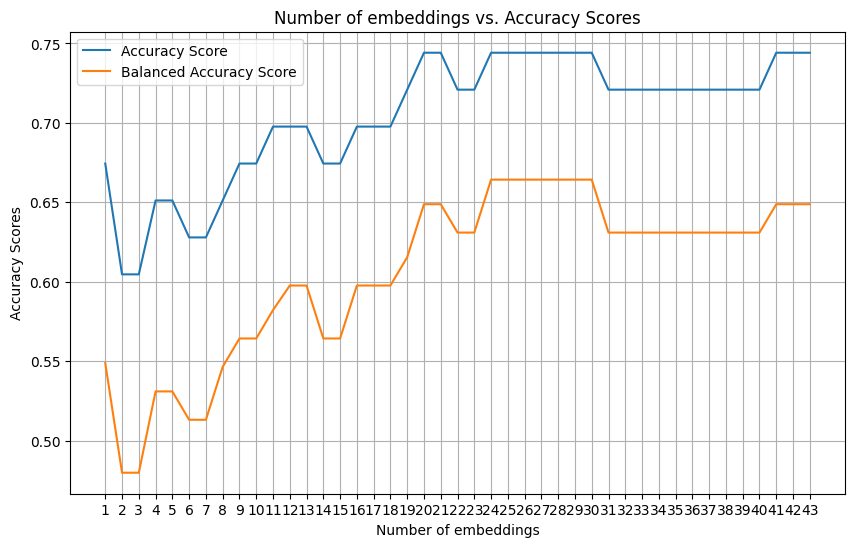


Number of frames around attack: 16



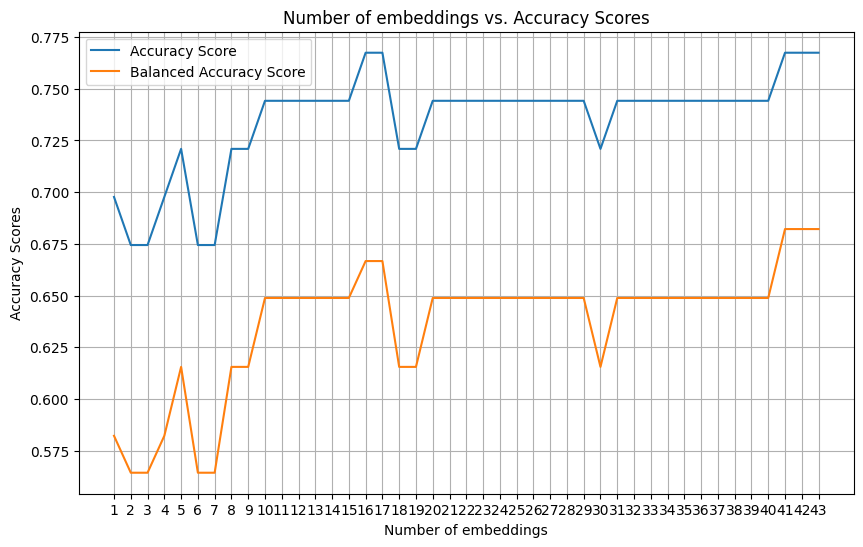


Number of frames around attack: 18



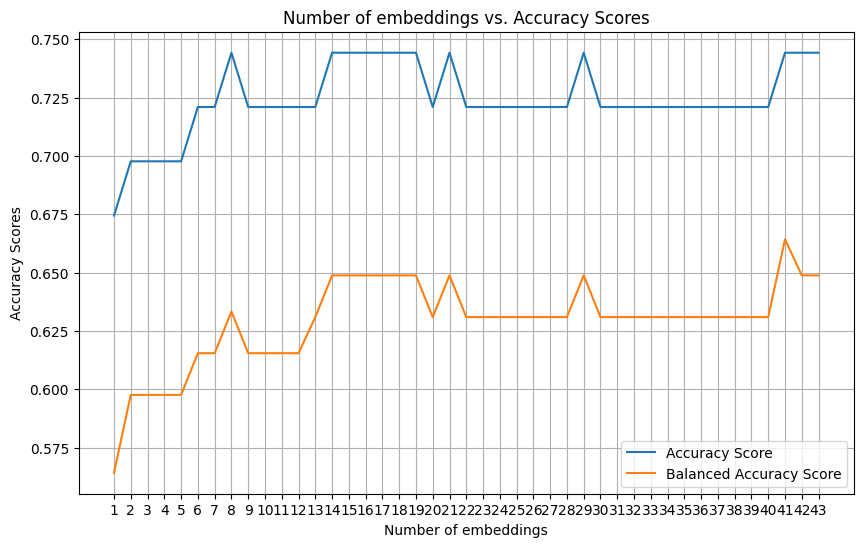


Number of frames around attack: 20



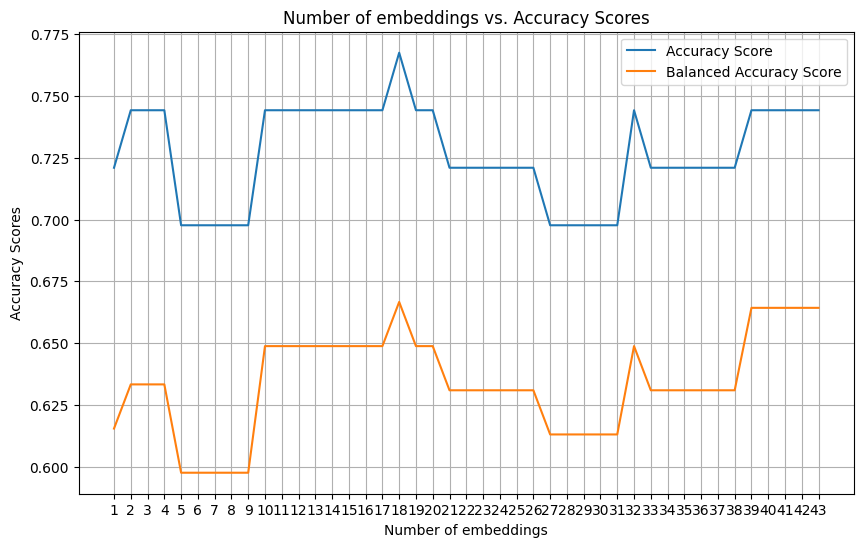


Number of frames around attack: 22



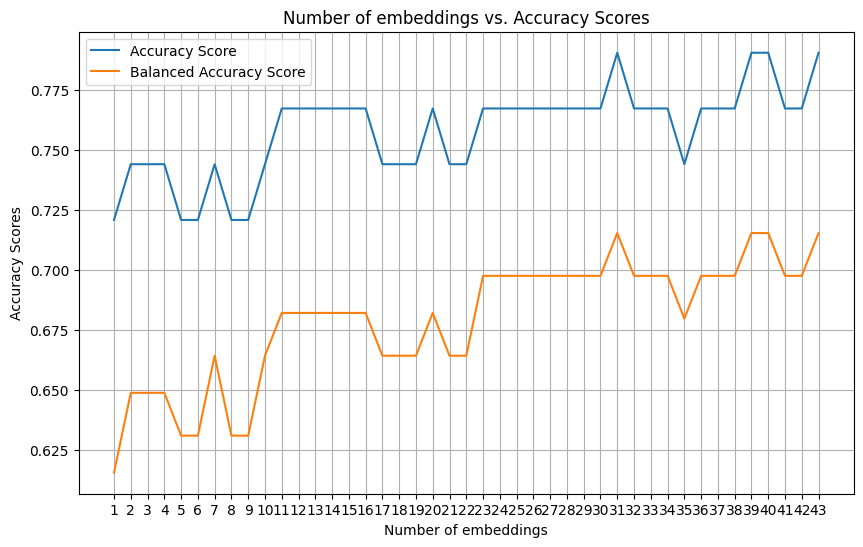


Number of frames around attack: 24



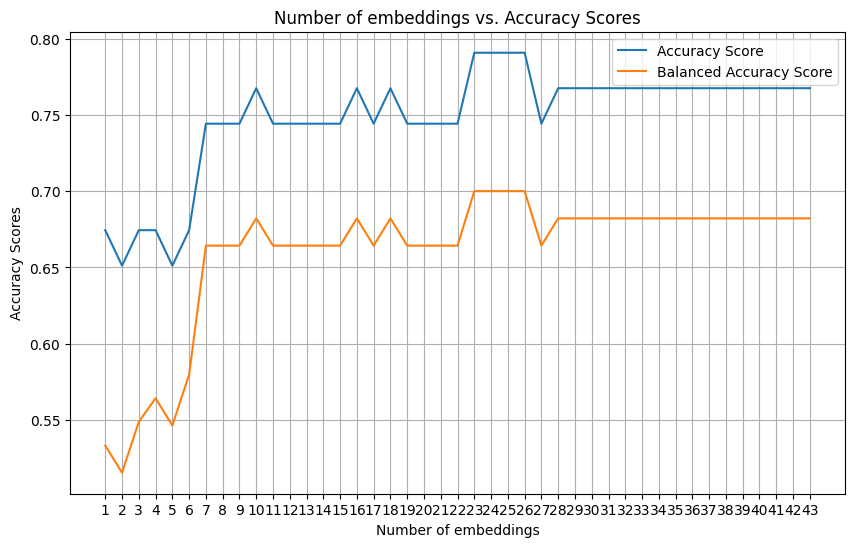


Number of frames around attack: 26



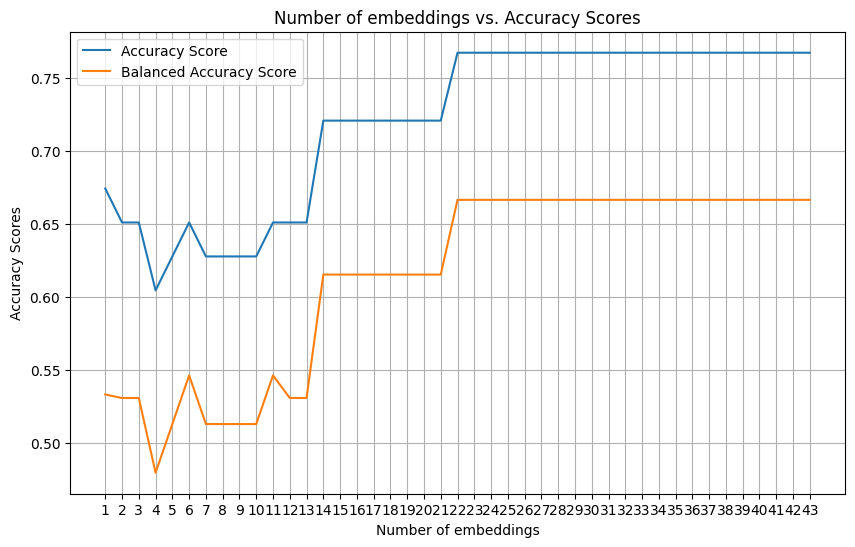


Number of frames around attack: 28



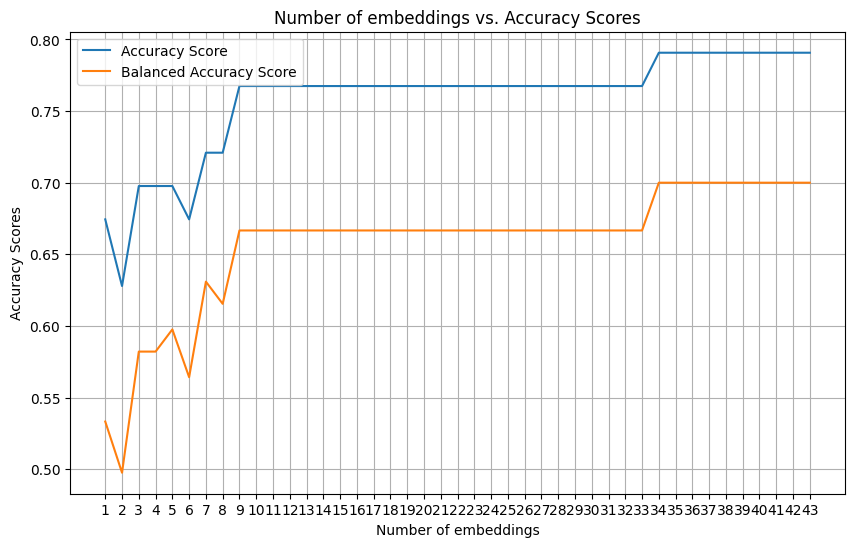


Number of frames around attack: 30



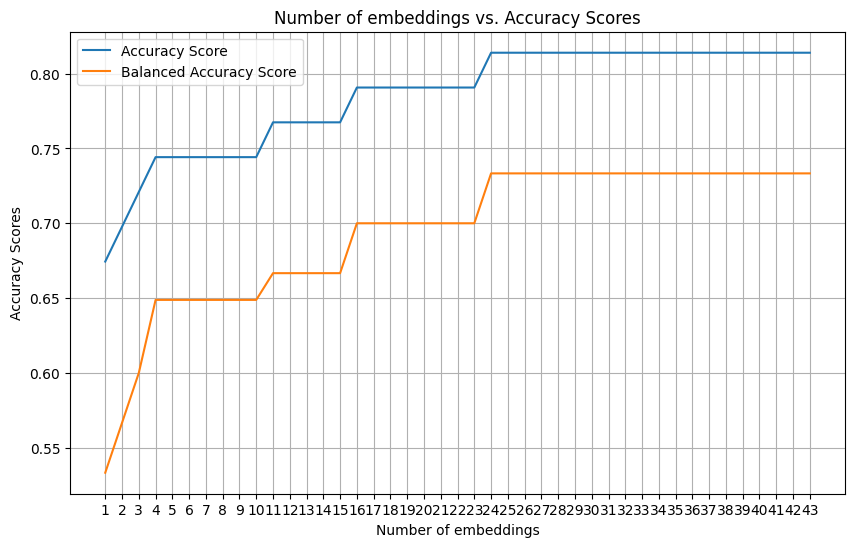

In [23]:
for num_frames_around_attack in range(14, 31, 2):
    ra_embeddings = {}

    print(f'\nNumber of frames around attack: {num_frames_around_attack}\n')

    for video, attack_frame in attack_frames.items():
        vid_path = JSON_DATA_DIR + video
        analyser = VolleyWrapper(vid_path, vid_path, window_size=num_frames_around_attack, stride=num_frames_around_attack)
        embeddings = analyser.embeddings(analyser.seq1[:, :, attack_frame - num_frames_around_attack // 2: attack_frame + num_frames_around_attack // 2], num_frames_around_attack, num_frames_around_attack)
        ra_embeddings[video] = embeddings[0][0]

    ra_embeddings = pd.DataFrame(ra_embeddings).T
    embs_len = len(ra_embeddings.columns)
    ra_embeddings.columns = [f'emb_{i}' for i in range(embs_len)]
    ra_embeddings['json_file'] = ra_embeddings.index
    ra_embeddings = ra_embeddings.reset_index(drop=True)
    ra_embeddings = ra_embeddings.merge(scores[['slagarm_hoek_score', 'positie_tov_bal_score', 'totaal_score', 'json_file']])
    y = ra_embeddings['positie_tov_bal_score']

    plot_num_top_emb_vs_acc(ra_embeddings[[f'emb_{i}' for i in range(embs_len)]], y, 43)

## Check whether top 10 PCA give any good res
### R2 scores for regression on PCA: 
#### - X is top n principal components (based on top n principal components)
#### - y is arm angle score (slagarm_hoek_score)

In [25]:
def plot_pca_explained_var_ratio_vs_r2(X, y, max_n_components=20):
    """
    Plots the explained variance ratio and R-squared score of a model trained
    on PCA-transformed data with different numbers of components.

    Args:
        X (array-like): The data matrix.
        y (array-like): The target variable vector.
        model (object): The machine learning model object.
    """

    n_components = range(1, max_n_components + 1)  # Number of components to try
    explained_variance_ratio = []
    r2_scores = []
    adjusted_r2_scores = []

    for n in n_components:
        # Perform PCA
        pca = PCA(n_components=n)
        X_transformed = pca.fit_transform(X)

        model = LinearRegression()
        # Train the model
        model.fit(X_transformed, y)

        # Evaluate the model
        explained_variance_ratio.append(pca.explained_variance_ratio_.sum())
        r2_scores.append(model.score(X_transformed, y))
        adjusted_r2_scores.append(adjusted_r2(r2_scores[-1], X_transformed.shape[0], X_transformed.shape[1]))

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(n_components, explained_variance_ratio, label='Explained Variance Ratio')
    plt.plot(n_components, r2_scores, label='R-squared Score')
    plt.plot(n_components, adjusted_r2_scores, label='Adjusted R-squared Score')
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Explained Variance Ratio / R-squared Score')
    plt.title('PCA Explained Variance Ratio vs. R-squared Score')
    plt.legend()
    plt.xticks(n_components)
    plt.grid(True)
    plt.show()


Number of frames around attack: 14



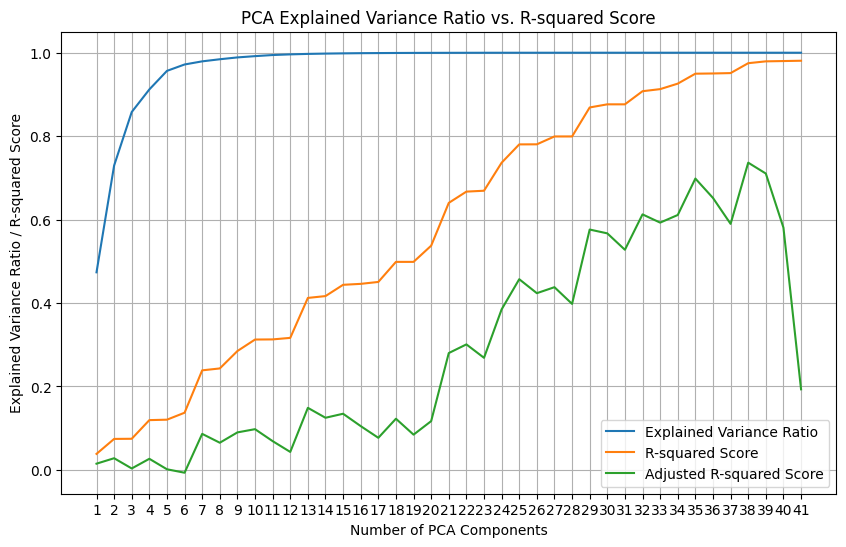


Number of frames around attack: 16



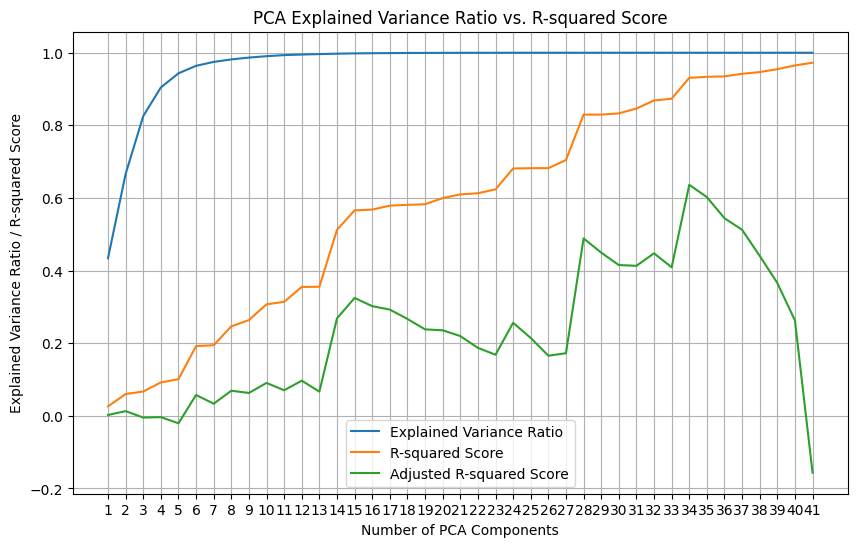


Number of frames around attack: 18



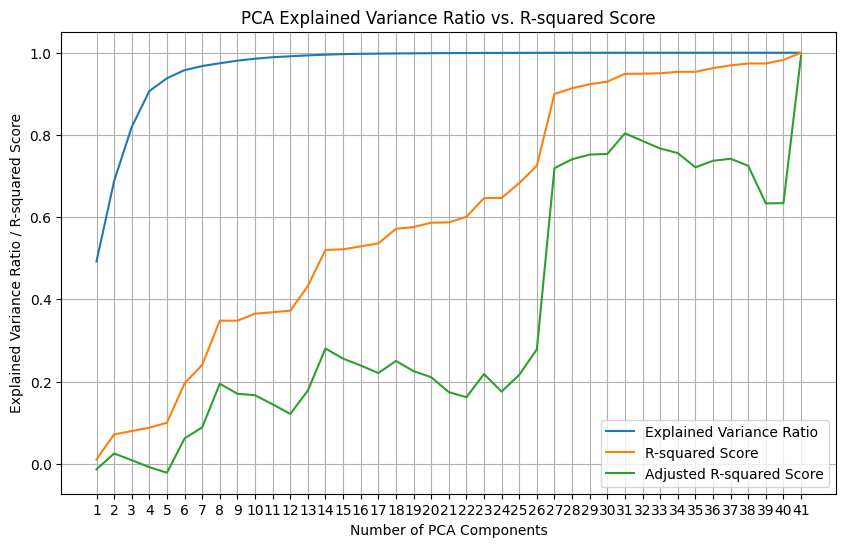


Number of frames around attack: 20



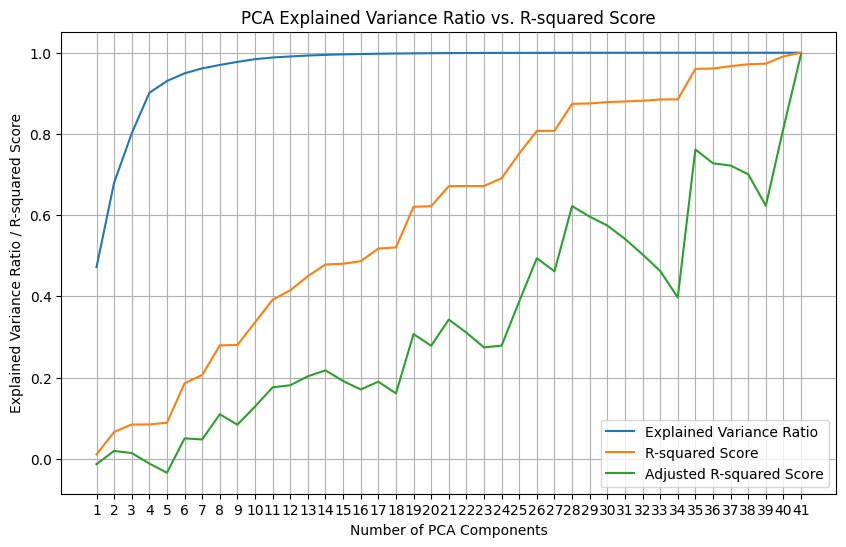


Number of frames around attack: 22



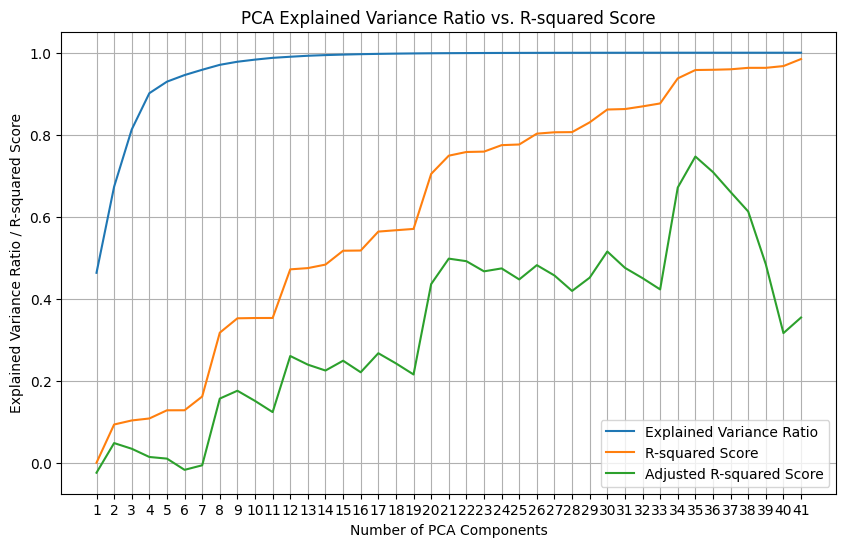


Number of frames around attack: 24



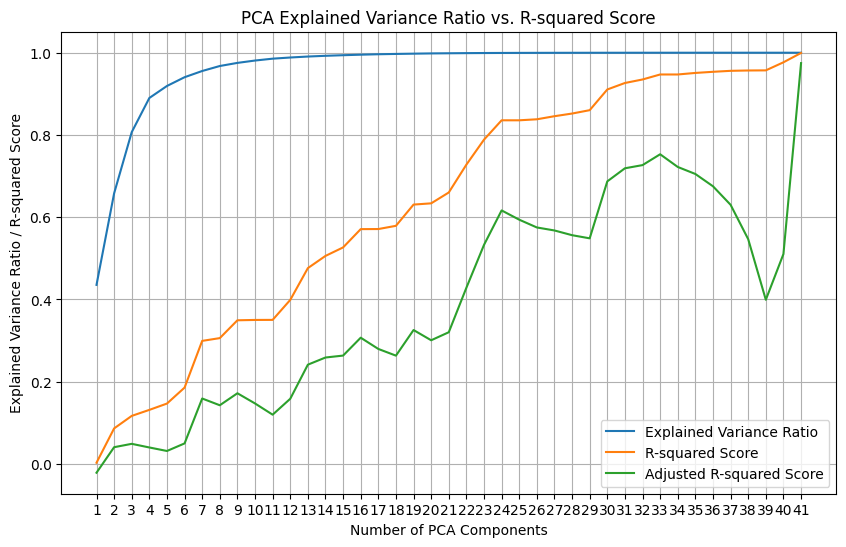


Number of frames around attack: 26



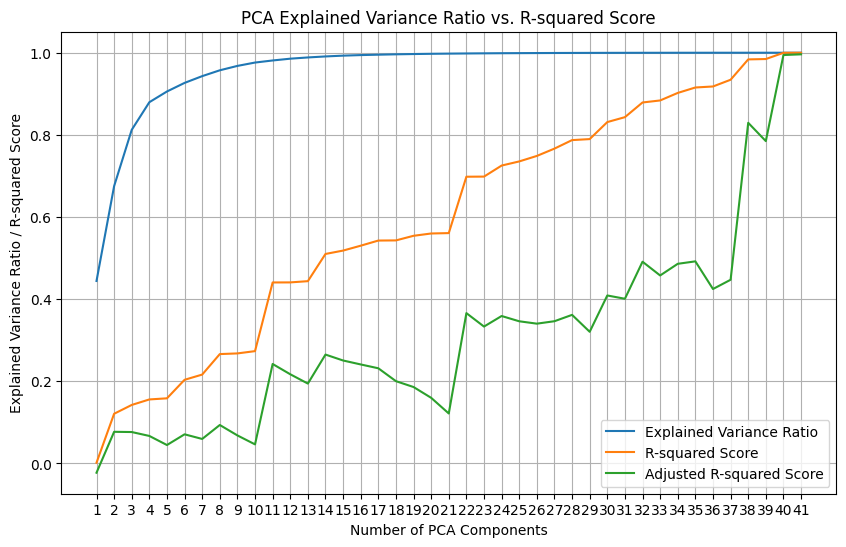


Number of frames around attack: 28



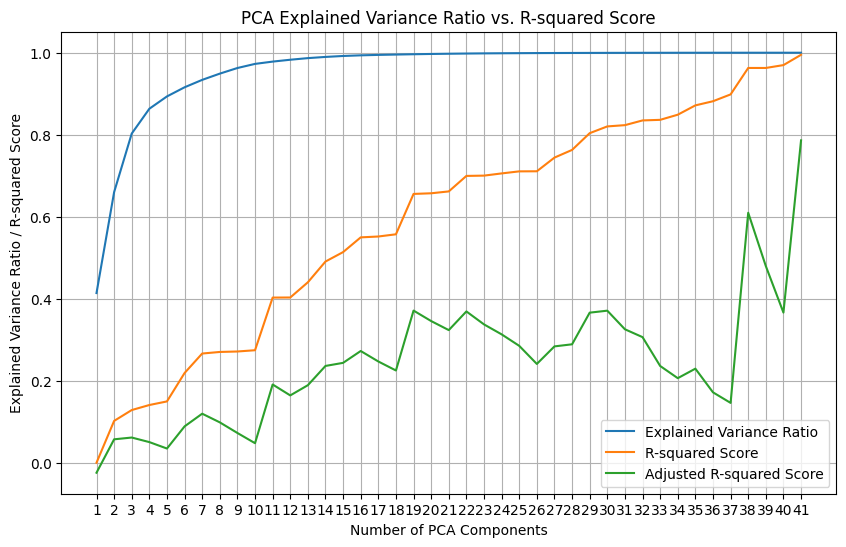


Number of frames around attack: 30



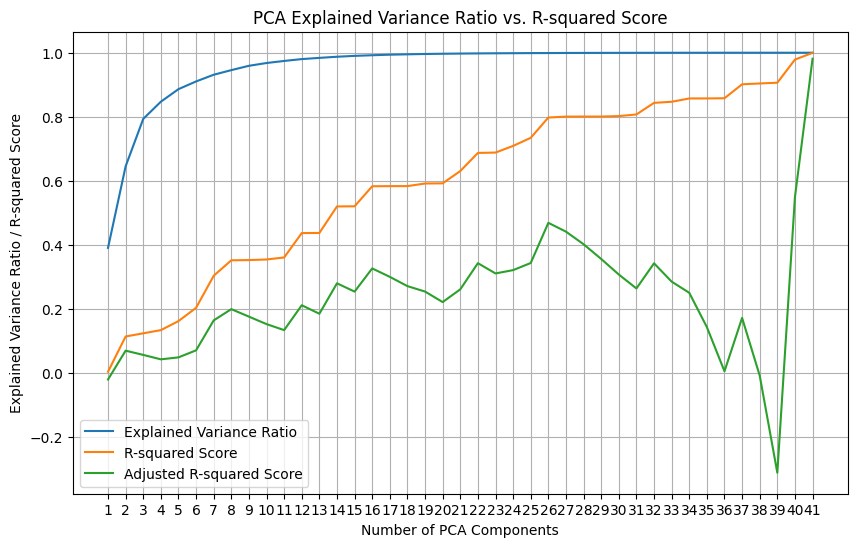

In [28]:
for num_frames_around_attack in range(14, 31, 2):
    ra_embeddings = {}

    print(f'\nNumber of frames around attack: {num_frames_around_attack}\n')

    for video, attack_frame in attack_frames.items():
        vid_path = JSON_DATA_DIR + video
        analyser = VolleyWrapper(vid_path, vid_path, window_size=num_frames_around_attack, stride=num_frames_around_attack)
        embeddings = analyser.embeddings(analyser.seq1[:, :, attack_frame - num_frames_around_attack // 2: attack_frame + num_frames_around_attack // 2], num_frames_around_attack, num_frames_around_attack)
        ra_embeddings[video] = embeddings[0][0]

    ra_embeddings = pd.DataFrame(ra_embeddings).T
    embs_len = len(ra_embeddings.columns)
    ra_embeddings.columns = [f'emb_{i}' for i in range(embs_len)]
    ra_embeddings['json_file'] = ra_embeddings.index
    ra_embeddings = ra_embeddings.reset_index(drop=True)
    ra_embeddings = ra_embeddings.merge(scores[['slagarm_hoek_score', 'positie_tov_bal_score', 'totaal_score', 'json_file']])
    y = ra_embeddings['slagarm_hoek_score']

    plot_pca_explained_var_ratio_vs_r2(ra_embeddings[[f'emb_{i}' for i in range(embs_len)]], y, 41)

### Accuracy for classification -- PCA
#### - X is top n principal components (based on PCA transformed data)
#### - y is arm position score (positie_tov_bal_score)

In [33]:
def plot_pca_explained_var_ratio_vs_acc(df, y, max_n_components=20):
    """
    Plots the explained variance ratio and balanced accuracy score of a logistic regression model trained
    on top n embeddings.

    Args:
        df (dataframe): The feature dataframe with the original embeddings.
        y (array-like): The target variable vector.
    """

    n_components = range(1, max_n_components + 1)  # Number of components to try
    explained_variance_ratio = []
    acc_scores = []
    balanced_acc_scores = []

    for n in n_components:
        # Perform PCA
        pca = PCA(n_components=n)
        X_transformed = pca.fit_transform(df)

        model = LogisticRegression()
        # Train the model
        model.fit(X_transformed, y)
        pred = model.predict(X_transformed)

        # Evaluate the model
        explained_variance_ratio.append(pca.explained_variance_ratio_.sum())
        acc_scores.append(model.score(X_transformed, y))
        balanced_acc_scores.append(balanced_accuracy_score(y, pred))

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(n_components, explained_variance_ratio, label='Explained Variance Ratio')
    plt.plot(n_components, acc_scores, label='Accuracy Score')
    plt.plot(n_components, balanced_acc_scores, label='Balanced Accuracy Score')
    plt.xlabel('Number of embeddings')
    plt.ylabel('Accuracy Scores')
    plt.title('Number of components vs. Accuracy Scores')
    plt.legend()
    plt.xticks(n_components)
    plt.grid(True)
    plt.show()


Number of frames around attack: 14



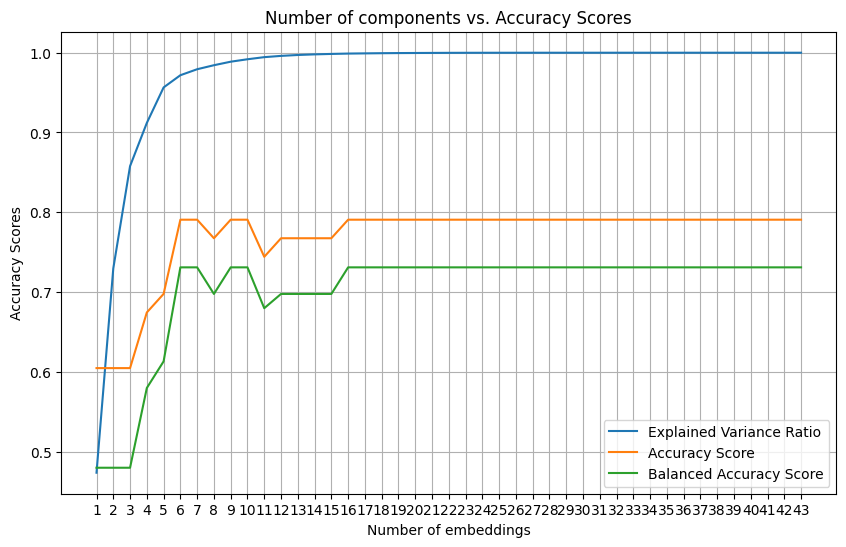


Number of frames around attack: 16



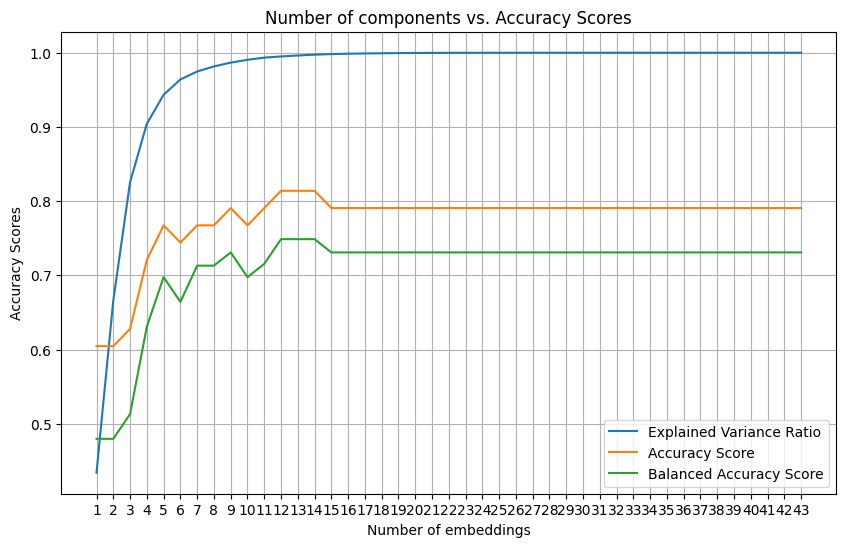


Number of frames around attack: 18



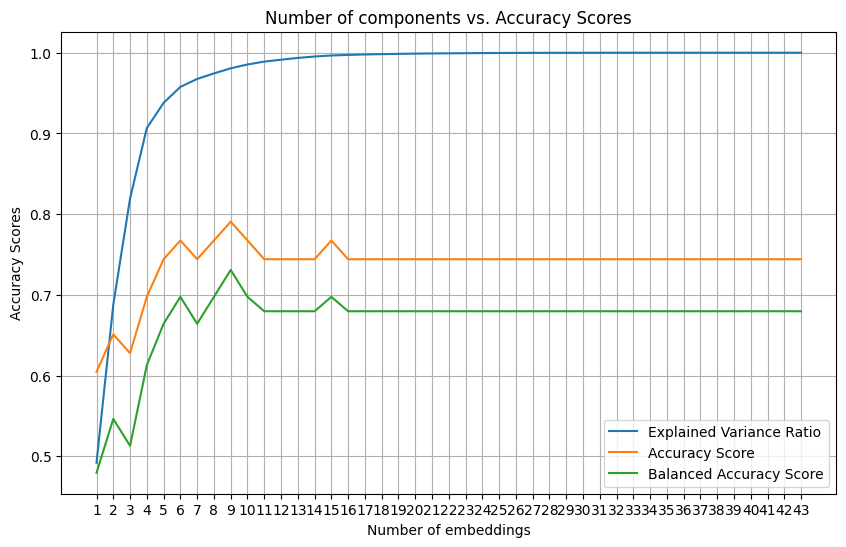


Number of frames around attack: 20



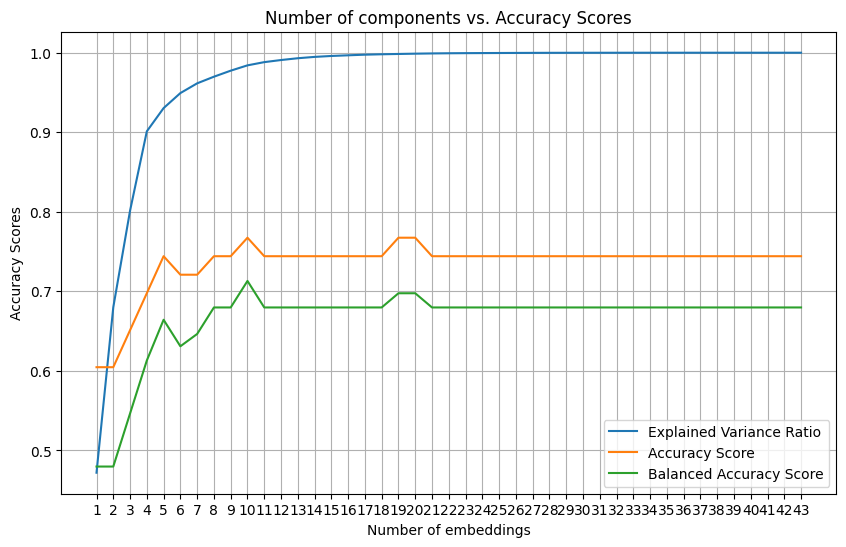


Number of frames around attack: 22



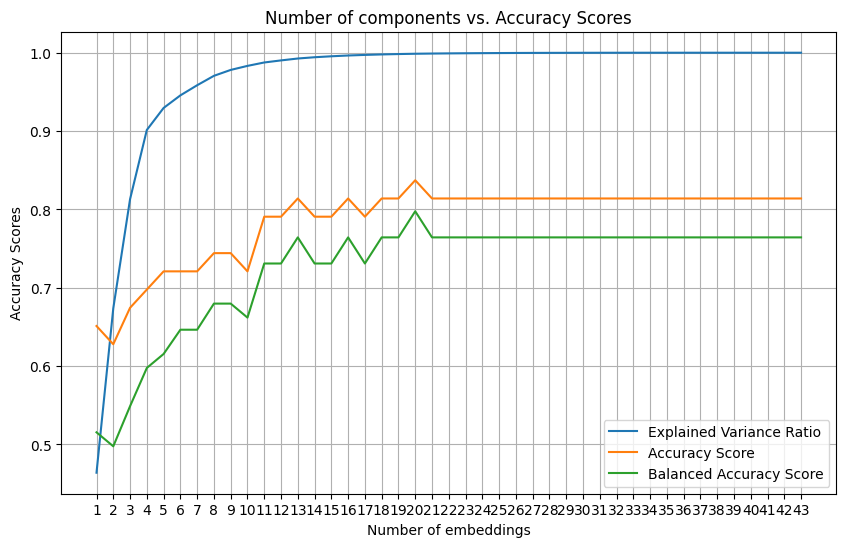


Number of frames around attack: 24



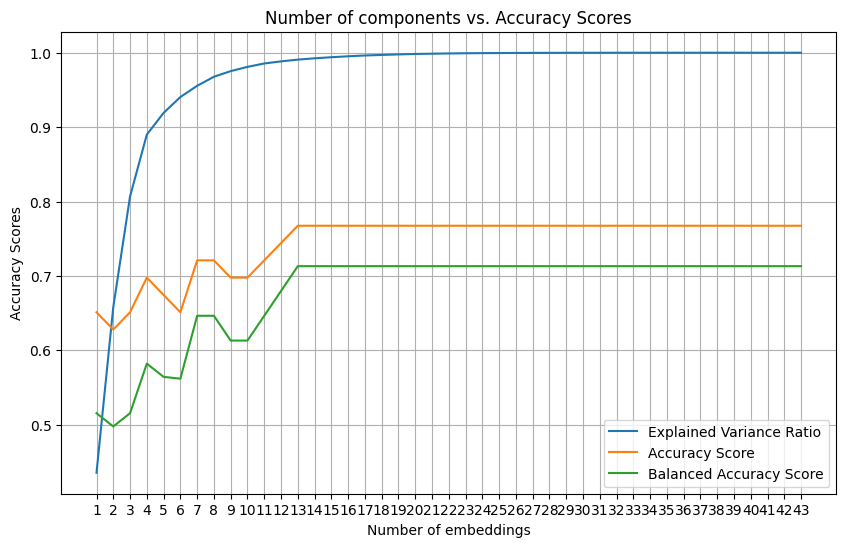


Number of frames around attack: 26



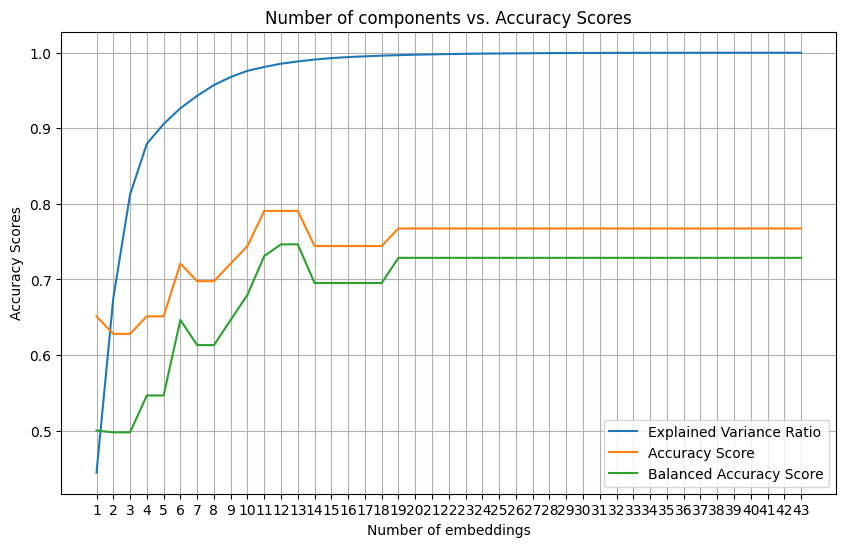


Number of frames around attack: 28



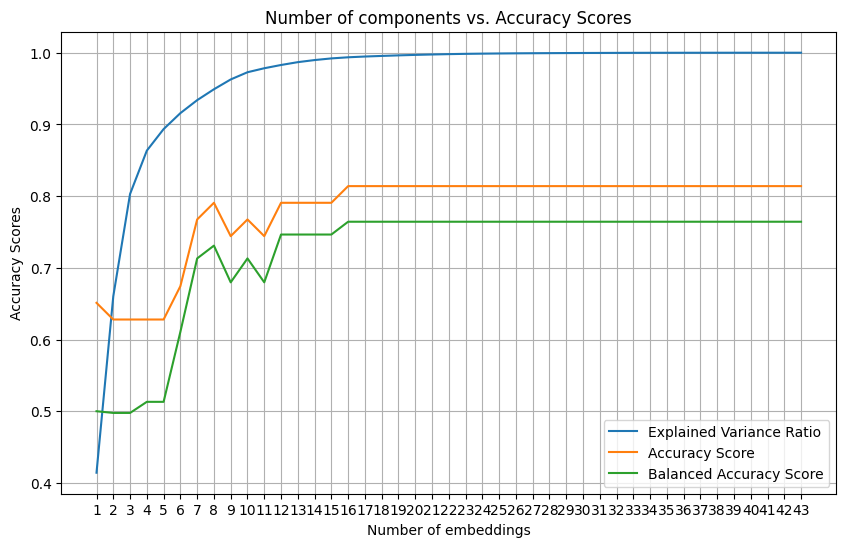


Number of frames around attack: 30



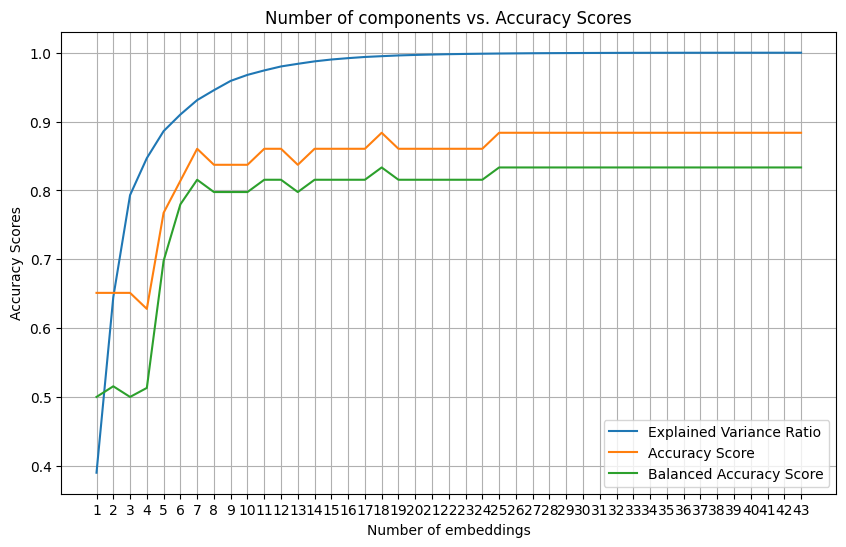

In [34]:
for num_frames_around_attack in range(14, 31, 2):
    ra_embeddings = {}

    print(f'\nNumber of frames around attack: {num_frames_around_attack}\n')

    for video, attack_frame in attack_frames.items():
        vid_path = JSON_DATA_DIR + video
        analyser = VolleyWrapper(vid_path, vid_path, window_size=num_frames_around_attack, stride=num_frames_around_attack)
        embeddings = analyser.embeddings(analyser.seq1[:, :, attack_frame - num_frames_around_attack // 2: attack_frame + num_frames_around_attack // 2], num_frames_around_attack, num_frames_around_attack)
        ra_embeddings[video] = embeddings[0][0]

    ra_embeddings = pd.DataFrame(ra_embeddings).T
    embs_len = len(ra_embeddings.columns)
    ra_embeddings.columns = [f'emb_{i}' for i in range(embs_len)]
    ra_embeddings['json_file'] = ra_embeddings.index
    ra_embeddings = ra_embeddings.reset_index(drop=True)
    ra_embeddings = ra_embeddings.merge(scores[['slagarm_hoek_score', 'positie_tov_bal_score', 'totaal_score', 'json_file']])
    y = ra_embeddings['positie_tov_bal_score']

    plot_pca_explained_var_ratio_vs_acc(ra_embeddings[[f'emb_{i}' for i in range(embs_len)]], y, 43)